In [2]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'F:/face2/face-recognition-master/models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [3]:
from model import create_model

nn4_small2 = create_model()

Using TensorFlow backend.


In [4]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [5]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('F:/face2/face-recognition-master/weights/nn4.small2.v1.h5')

In [6]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg' or ext == '.JPG':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('F:/finalprep/face80x/train')
metadata1 = load_metadata('F:/finalprep/face80x/valid')

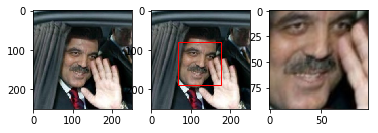

In [7]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    #return img[...,::-1]
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #cv2.imshow("g" , img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    return img

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('F:/face2/face-recognition-master/models/landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[2].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);


In [8]:

def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [9]:
import cv2
good_image_indx = []
unfit_image_indx = []
count=0
ass=[]
embedded = np.zeros((metadata.shape[0], 128))
for i, m in enumerate(metadata):
    try:
        img = load_image(m.image_path())
        img = align_image(img)
    except:
        print("for new error",m.image_path())
    try:
        img = (img / 255.).astype(np.float32)
    except TypeError:
        unfit_image_indx.append(i)
        count+=1
        print(m.image_path())
        print("The image is not Clear to extract the Embeddings")
    else:
        embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
        good_image_indx.append(i)
        #ass.append(embedded[i])
print(len(embedded[i]))
#print(ass.shape)
#print(len(ass))
        
#metadata = metadata[good_image_indx]
#embedded = embedded[good_image_indx]
print(count)

128
0


In [10]:
#for validation of face
good_image_indx = []
unfit_image_indx = []
count=0
ass=[]
embedded1 = np.zeros((metadata1.shape[0], 128))
for i, m in enumerate(metadata1):
    img = load_image(m.image_path())
    img = align_image(img)
    try:
        img = (img / 255.).astype(np.float32)
    except TypeError:
        unfit_image_indx.append(i)
        count+=1
        print(m.image_path())
        print("The image is not Clear to extract the Embeddings")
    else:
        embedded1[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
        good_image_indx.append(i)
        #ass.append(embedded[i])
print(len(embedded1[i]))
#print(ass.shape)
#print(len(ass))
        
#metadata = metadata[good_image_indx]
#embedded = embedded[good_image_indx]
print(count)

128
0


In [11]:
print(len(embedded))

640


In [10]:
#till here face

In [12]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

vgg_conv_new = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [13]:
train_dir = 'F:/concatenation/iris38/train'
validation_dir = 'F:/concatenation/iris38/valid'

In [14]:
nTrain = 300 #folder number 24 has 4 imgs only so 
nVal = 65 #folder 1 to 10 have 1 img, 11 to 38 ,except 24(has one img) have 2 imgs

In [15]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from random import shuffle
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 4
 
train_features = np.zeros(shape=(nTrain, 7,7,512))
train_labels = np.zeros(shape=(nTrain,38))
 
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=None)

Found 300 images belonging to 38 classes.


In [16]:
i = 0
nImages=300
for inputs_batch, labels_batch in train_generator:
    features_batch = vgg_conv_new.predict(inputs_batch)
    train_features[i * batch_size : (i + 1) * batch_size] = features_batch
    train_labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= nImages:
        break
         
train_features = np.reshape(train_features, (nTrain, 7*7*512))

In [60]:
val_features = np.zeros(shape=(nVal, 7,7,512))
val_labels = np.zeros(shape=(nVal,38))
 
val_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=None)
i = 0
nImages1=65
for inputs_batch, labels_batch1 in val_generator:
    features_batch1 = vgg_conv_new.predict(inputs_batch)
    val_features[i * batch_size : (i + 1) * batch_size] = features_batch1
    val_labels[i * batch_size : (i + 1) * batch_size] = labels_batch1
    i += 1
    if i * batch_size >= nImages1:
        break
         
val_features = np.reshape(val_features, (nVal, 25088))
print(val_labels)

Found 65 images belonging to 38 classes.
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [18]:
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dropout
#from keras.layers import random
import random
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512,name ='den'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(38, activation='softmax'))

In [19]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
 
history = model.fit(train_features,
                    train_labels,
                    epochs=15,
                    batch_size=batch_size,
                    validation_data=(val_features,val_labels))

Train on 300 samples, validate on 65 samples
Epoch 1/15
300/300 [==============================] - 13s 43ms/step - loss: 3.8157 - acc: 0.0533 - val_loss: 3.1972 - val_acc: 0.2000
Epoch 2/15
300/300 [==============================] - 10s 33ms/step - loss: 3.0184 - acc: 0.2000 - val_loss: 2.4923 - val_acc: 0.5538
Epoch 3/15
300/300 [==============================] - 10s 33ms/step - loss: 2.3212 - acc: 0.3967 - val_loss: 1.9467 - val_acc: 0.7077
Epoch 4/15
300/300 [==============================] - 10s 32ms/step - loss: 1.7819 - acc: 0.5800 - val_loss: 1.4852 - val_acc: 0.8462
Epoch 5/15
300/300 [==============================] - 10s 33ms/step - loss: 1.3973 - acc: 0.6533 - val_loss: 1.1526 - val_acc: 0.9077
Epoch 6/15
300/300 [==============================] - 10s 33ms/step - loss: 1.0715 - acc: 0.7733 - val_loss: 0.9612 - val_acc: 0.9077
Epoch 7/15
300/300 [==============================] - 10s 33ms/step - loss: 0.8054 - acc: 0.8567 - val_loss: 0.7730 - val_acc: 0.9077
Epoch 8/15
300/30

In [61]:
print(train_features.shape)
print(val_features.shape)

(300, 25088)
(65, 25088)


In [21]:
model_new = Model(input=model.input, output=model.get_layer('den').output)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [22]:
############# features for 80 classess ##############

In [23]:
train_dir80 = 'F:/finalprep/iris80x/train'
validation_dir80 = 'F:/finalprep/iris80x/valid'

In [24]:
nTrain80 = 640 #folder number 24 has 4 imgs only so 
nVal80 = 160 #folder 1 to 10 have 1 img, 11 to 38 ,except 24(has one img) have 2 imgs

In [25]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from random import shuffle
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 4
 
train_features80 = np.zeros(shape=(nTrain80, 7,7,512))
train_labels80 = np.zeros(shape=(nTrain80,80))
 
train_generator = datagen.flow_from_directory(
    train_dir80,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=None)

Found 640 images belonging to 80 classes.


In [26]:
i = 0
nImages80=640
for inputs_batch80, labels_batch80 in train_generator:
    features_batch80 = vgg_conv_new.predict(inputs_batch80)
    train_features80[i * batch_size : (i + 1) * batch_size] = features_batch80
    train_labels80[i * batch_size : (i + 1) * batch_size] = labels_batch80
    i += 1
    if i * batch_size >= nImages80:
        break
         
train_features80 = np.reshape(train_features80, (nTrain80, 7*7*512))

In [27]:
val_features81 = np.zeros(shape=(nVal80, 7,7,512))
val_labels81 = np.zeros(shape=(nVal80,80))
 
val_generator = datagen.flow_from_directory(
    validation_dir80,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=None)
i = 0
nImages81=160
for inputs_batch81, labels_batch81 in val_generator:
    features_batch81 = vgg_conv_new.predict(inputs_batch81)
    val_features81[i * batch_size : (i + 1) * batch_size] = features_batch81
    val_labels81[i * batch_size : (i + 1) * batch_size] = labels_batch81
    i += 1
    if i * batch_size >= nImages81:
        break
         
val_features81 = np.reshape(val_features81, (nVal80, 25088))
print(val_labels81)

Found 160 images belonging to 80 classes.
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [28]:
print(val_features81.shape)
print(train_features80.shape)

(160, 25088)
(640, 25088)


In [29]:
#####the train_features one by one are being reshaped to (1,25088),by first reshping and then transposing to get (1,25088)###
feaa=[]
for i in range(nImages80):
    fea=(np.reshape(train_features80[i], (25088,1)))
    c = (model_new.predict(fea.transpose()))
    feaa.append(c[0])
print(len(feaa),len(feaa[0]))

640 256


In [30]:
####same for val_features#####
valf=[]
for i in range(nImages81):
    f=(np.reshape(val_features81[i], (25088,1)))
    c = (model_new.predict(f.transpose()))
    valf.append(c[0])
###print###
valf=np.array(valf)
print('valf',valf.shape)
feaa = np.array(feaa)
print('feaa',feaa.shape)

valf (160, 256)
feaa (640, 256)


In [31]:
### these labels are created for ml classifiers ,not needed if a simple nn is used, for that train_labels,va_lables is enough#
##these are the lables for training dataset#####
labels = []
for i in range(80):
    for j in range(8):
        labels.append(str(i))
print(labels)

['0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '2', '2', '2', '2', '3', '3', '3', '3', '3', '3', '3', '3', '4', '4', '4', '4', '4', '4', '4', '4', '5', '5', '5', '5', '5', '5', '5', '5', '6', '6', '6', '6', '6', '6', '6', '6', '7', '7', '7', '7', '7', '7', '7', '7', '8', '8', '8', '8', '8', '8', '8', '8', '9', '9', '9', '9', '9', '9', '9', '9', '10', '10', '10', '10', '10', '10', '10', '10', '11', '11', '11', '11', '11', '11', '11', '11', '12', '12', '12', '12', '12', '12', '12', '12', '13', '13', '13', '13', '13', '13', '13', '13', '14', '14', '14', '14', '14', '14', '14', '14', '15', '15', '15', '15', '15', '15', '15', '15', '16', '16', '16', '16', '16', '16', '16', '16', '17', '17', '17', '17', '17', '17', '17', '17', '18', '18', '18', '18', '18', '18', '18', '18', '19', '19', '19', '19', '19', '19', '19', '19', '20', '20', '20', '20', '20', '20', '20', '20', '21', '21', '21', '21', '21', '21', '21', '21', '22', '22', '22', '22',

In [32]:
###labels for val dataset####
tes_labels = []
for i in range(80):
    for k in range(2):
        tes_labels.append(str(i))
print(tes_labels)

['0', '0', '1', '1', '2', '2', '3', '3', '4', '4', '5', '5', '6', '6', '7', '7', '8', '8', '9', '9', '10', '10', '11', '11', '12', '12', '13', '13', '14', '14', '15', '15', '16', '16', '17', '17', '18', '18', '19', '19', '20', '20', '21', '21', '22', '22', '23', '23', '24', '24', '25', '25', '26', '26', '27', '27', '28', '28', '29', '29', '30', '30', '31', '31', '32', '32', '33', '33', '34', '34', '35', '35', '36', '36', '37', '37', '38', '38', '39', '39', '40', '40', '41', '41', '42', '42', '43', '43', '44', '44', '45', '45', '46', '46', '47', '47', '48', '48', '49', '49', '50', '50', '51', '51', '52', '52', '53', '53', '54', '54', '55', '55', '56', '56', '57', '57', '58', '58', '59', '59', '60', '60', '61', '61', '62', '62', '63', '63', '64', '64', '65', '65', '66', '66', '67', '67', '68', '68', '69', '69', '70', '70', '71', '71', '72', '72', '73', '73', '74', '74', '75', '75', '76', '76', '77', '77', '78', '78', '79', '79']


In [33]:
#####concat#########
import numpy as np
c=[]
a=embedded
b=feaa
for i in range(len(b)):
    c.append(np.concatenate((a[i], b[i]), axis=0))
c=np.array(c)
print(len((c)))
d=[]
e=embedded1
f=valf
for i in range(len(e)):
    d.append(np.concatenate((e[i],f[i]),axis=0))
d=np.array(d)
print(len(d))

640
160


In [34]:
print(len(c[0]))

384


In [11]:
#####################iris 256############################

In [ ]:
#####################classification of 256 iris#####################

In [ ]:
###################iris 256 class############### +face down#################

In [43]:
import numpy as np
c=[]
a=embedded
b=feaa
for i in range(len(b)):
    c.append(np.concatenate((a[i], b[i]), axis=0))
c=np.array(c)
print(len((c)))
d=[]
e=embedded1
f=valf
for i in range(len(e)):
    d.append(np.concatenate((e[i],f[i]),axis=0))
d=np.array(d)
print(len(d))

640
160


In [80]:
from keras import models
from keras import layers
from keras import optimizers
from keras.models import Sequential
 
model = Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=384))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

In [81]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-4),
              loss='categorical_crossentropy',
              metrics=['acc'])
 
history = model.fit(c,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(d,val_labels))

Train on 80 samples, validate on 10 samples
Epoch 1/10
80/80 [==============================] - 3s 33ms/step - loss: 2.7719 - acc: 0.1875 - val_loss: 1.5290 - val_acc: 0.5000
Epoch 2/10
80/80 [==============================] - 0s 3ms/step - loss: 1.8204 - acc: 0.4125 - val_loss: 0.8558 - val_acc: 1.0000
Epoch 3/10
80/80 [==============================] - 0s 3ms/step - loss: 1.1524 - acc: 0.6375 - val_loss: 0.4914 - val_acc: 1.0000
Epoch 4/10
80/80 [==============================] - ETA: 0s - loss: 0.7968 - acc: 0.776 - 0s 4ms/step - loss: 0.7755 - acc: 0.7875 - val_loss: 0.2909 - val_acc: 1.0000
Epoch 5/10
80/80 [==============================] - 0s 4ms/step - loss: 0.4908 - acc: 0.8875 - val_loss: 0.1742 - val_acc: 1.0000
Epoch 6/10
80/80 [==============================] - 0s 3ms/step - loss: 0.2788 - acc: 0.9375 - val_loss: 0.1104 - val_acc: 1.0000
Epoch 7/10
80/80 [==============================] - 0s 4ms/step - loss: 0.2177 - acc: 0.9875 - val_loss: 0.0664 - val_acc: 1.0000
Epoch 8

In [129]:
metadata2 = load_metadata('F:/concatenation/face images/test/Vladimir_Putin/')

In [130]:
good_image_indx = []
unfit_image_indx = []
count=0
ass=[]
embeddedt = np.zeros((metadata2.shape[0], 128))
for i, m in enumerate(metadata2):
    img = load_image(m.image_path())
    img = align_image(img)
    try:
        img = (img / 255.).astype(np.float32)
    except TypeError:
        unfit_image_indx.append(i)
        count+=1
        print("The image is not Clear to extract the Embeddings")
    else:
        embeddedt[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
        good_image_indx.append(i)
        #ass.append(embedded[i])
print(len(embeddedt[i]))
#print(ass.shape)
#print(len(ass))
        
#metadata = metadata[good_image_indx]
#embedded = embedded[good_image_indx]
print(count)

128
0


In [131]:
'''#test=['110_L.bmp.jpg','210_L.bmp.jpg','310_L.bmp.jpg','410_L.bmp.jpg','510_L.bmp.jpg','610_L.bmp.jpg','710_L.bmp.jpg','810_L.bmp.jpg','910_L.bmp.jpg','1010_L.bmp.jpg']
#test_path='C:/Users/HP/Pictures/sample/008/10_L.bmp.jpg'
#test=['01_L.bmp.jpg','02_L.bmp.jpg','03_L.bmp.jpg','04_L.bmp.jpg','05_L.bmp.jpg','06_L.bmp.jpg','07_L.bmp.jpg','08_L.bmp.jpg','09_L.bmp.jpg','10_L.bmp.jpg']
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
import cv2
test_path='F:/concatenation/iris images/test/1010_L.bmp.jpg'
#test_path='C:/Users/HP/Pictures/sample/006/'
test_img=[]
from keras.applications.vgg16 import decode_predictions
temp_img=image.load_img(test_path,target_size=(224,224))
    #temp_img=image.load_img(test_path,target_size=(224,224))

test_img=image.img_to_array(temp_img)

test_img=preprocess_input(test_img)
test_img=test_img.reshape(1,224,224,3)
features = vgg_conv_new.predict(test_img)
features = np.reshape(features, (25088,1))
features = model_new.predict(features.transpose())
g=[]
h=embeddedt.tolist()
h= h[0]
features = features.tolist()
features = features[0]
#print(features,"fea:",h)
h.extend(features)
h=np.array(h)
h=np.reshape(h,(384,1))
#print(h,'len',len(h))
#new = np.concatenate(h[0],features[0])
#print(len(new),new)'''
'''ii=features
for i in range(len(ii)):
    g.append(np.concatenate((h[i],ii[i]),axis=0))
g=np.array(g)
print(len(g))'''

'''pre = (model.predict_classes(h.transpose()))

print(pre)'''

[9]


In [97]:
#print((h).shape)


(384,)


In [59]:
############## ml classifier ###############

In [36]:
####all ml models for classifying th e 256 dimensional features#######
import h5py
import numpy as np
import os
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=5, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

In [37]:
for name,i in models:
    clf=i
    clf.fit(c,labels)
    predicted=clf.predict(d)
    print("name",name,"accuracy",accuracy_score(tes_labels,predicted))

C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


name LR accuracy 0.75625


C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


name LDA accuracy 0.98125
name KNN accuracy 0.525
name CART accuracy 0.35
name RF accuracy 0.46875
name NB accuracy 0.71875


C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


name SVM accuracy 0.35


In [62]:
###############test###############3

In [38]:
metadata_test = load_metadata('F:/finalprep/face80x/test')
import cv2
good_image_indx = []
unfit_image_indx = []
count=0
ass=[]
embedded_test = np.zeros((metadata_test.shape[0], 128))
for i, m in enumerate(metadata_test):
    try:
        img = load_image(m.image_path())
        img = align_image(img)
    except:
        print("for new error",m.image_path())
    try:
        img = (img / 255.).astype(np.float32)
    except TypeError:
        unfit_image_indx.append(i)
        count+=1
        print(m.image_path())
        print("The image is not Clear to extract the Embeddings")
    else:
        embedded_test[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
        good_image_indx.append(i)
        #ass.append(embedded[i])
print(len(embedded_test[i]))
#print(ass.shape)
#print(len(ass))
        
#metadata = metadata[good_image_indx]
#embedded = embedded[good_image_indx]
print(count)

128
0


In [39]:
####for testing images####
#1.first extract features using vgg and then reshape them then transpose it to make them compatible to be reduced to 256 using 
#model_new ,(because this modle requires that much input only)
val_features1 = np.zeros(shape=(80, 7,7,512))
val_labels1 = np.zeros(shape=(80,80))
 
val_generator1 = datagen.flow_from_directory(
    'F:/finalprep/iris80x/test',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=None)
i = 0
nImages1=80
for inputs_batch, labels_batch1 in val_generator1:
    features_batch1 = vgg_conv_new.predict(inputs_batch)
    #eatures_batch1 = model_new.predict(features_batch1)
    val_features1[i* batch_size : (i + 1) * batch_size] = features_batch1
    val_labels1[i*batch_size : (i + 1) * batch_size] = labels_batch1
    i += 1
    if i * batch_size >= nImages1:
        break
        
############## testf is test features #############
val_features1= np.reshape(val_features1,(80, 25088))
testf=[]
for i in range(80):
    f=(np.reshape(val_features1[i], (25088,1)))
    c = (model_new.predict(f.transpose()))
    testf.append(c[0])
print(len(testf[0]))

Found 80 images belonging to 80 classes.
256


In [40]:
xyz=[]
y=embedded_test
f=testf
for i in range(len(y)):
    xyz.append(np.concatenate((y[i],f[i]),axis=0))
xyz=np.array(xyz)
print(len(xyz))

80


In [41]:
print(len(xyz[0]))
testlabels = []
for i in range(80):
    testlabels.append(str(i))
print(testlabels)

384
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79']


In [44]:
for name,i in models:
    clf=i
    clf.fit(c,labels)
    predicted=clf.predict(xyz)
    print("name",name,"accuracy",accuracy_score(testlabels,predicted))
    print(clf.predict(xyz)) #print the classes

C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


name LR accuracy 0.65
['27' '1' '79' '3' '39' '5' '6' '7' '8' '43' '10' '11' '12' '77' '14' '15'
 '16' '15' '18' '38' '20' '11' '22' '23' '24' '1' '26' '27' '38' '15' '30'
 '60' '43' '33' '34' '35' '11' '8' '38' '39' '40' '41' '42' '43' '44' '72'
 '46' '47' '48' '49' '50' '22' '5' '53' '54' '17' '69' '76' '46' '59' '60'
 '43' '62' '63' '64' '45' '66' '67' '8' '69' '18' '49' '72' '49' '74' '75'
 '76' '77' '78' '79']
name LDA accuracy 0.9125
['0' '1' '2' '3' '4' '5' '6' '7' '41' '9' '10' '7' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '17' '69' '57'
 '58' '59' '60' '32' '62' '63' '64' '47' '66' '67' '68' '69' '70' '71'
 '72' '73' '74' '75' '76' '77' '28' '79']
name KNN accuracy 0.3625
['19' '3' '47' '3' '25' '67' '40' '7' '67' '43' '10' '11' '12' '5' '14'
 '15' '16' '15' '56' '18' '79' '11' '22' '23' '17' '11' '26' '

C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


name CART accuracy 0.3375
['0' '1' '2' '56' '79' '76' '6' '1' '41' '30' '50' '41' '8' '76' '42' '15'
 '16' '71' '18' '19' '56' '1' '32' '54' '47' '28' '24' '68' '38' '29' '30'
 '31' '48' '33' '34' '35' '1' '2' '22' '43' '21' '41' '64' '10' '50' '2'
 '29' '1' '24' '49' '14' '21' '41' '69' '70' '45' '10' '76' '58' '63' '60'
 '10' '62' '63' '64' '65' '4' '67' '68' '58' '70' '66' '1' '23' '74' '47'
 '12' '77' '67' '66']
name RF accuracy 0.3875
['0' '1' '22' '64' '4' '12' '16' '11' '61' '10' '35' '11' '12' '13' '26'
 '15' '16' '18' '18' '41' '20' '19' '53' '2' '23' '28' '26' '27' '11' '20'
 '30' '31' '32' '33' '12' '24' '36' '12' '38' '15' '19' '41' '18' '43'
 '11' '11' '37' '21' '17' '29' '50' '41' '52' '53' '0' '17' '69' '19' '28'
 '59' '60' '10' '29' '63' '3' '65' '16' '9' '2' '69' '70' '19' '20' '50'
 '74' '19' '76' '44' '20' '20']
name NB accuracy 0.675
['0' '1' '2' '3' '5' '5' '6' '7' '8' '9' '10' '11' '2' '77' '14' '15' '77'
 '17' '18' '19' '20' '11' '22' '23' '24' '11' '26' '27' '28

C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


name SVM accuracy 0.375
['28' '36' '57' '3' '4' '67' '15' '7' '8' '43' '10' '13' '12' '52' '14'
 '15' '16' '4' '11' '21' '42' '11' '22' '49' '24' '28' '26' '27' '38' '15'
 '30' '45' '43' '33' '34' '14' '11' '37' '71' '41' '40' '17' '44' '43' '7'
 '71' '43' '22' '48' '49' '50' '22' '4' '15' '26' '17' '69' '36' '44' '28'
 '4' '43' '62' '63' '63' '79' '26' '67' '8' '69' '26' '63' '72' '49' '74'
 '49' '76' '71' '26' '79']


In [ ]:
###########svm#########

In [54]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2 ,1e-3, 1e-4],
                     'C': [1,5, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1,5, 10, 100, 1000]}]

In [55]:
from sklearn.model_selection import GridSearchCV
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(c, labels)

C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'C': [1, 5, 10, 100, 1000], 'gamma': [0.1, 0.01, 0.001, 0.0001], 'kernel': ['rbf']}, {'C': [1, 5, 10, 100, 1000], 'kernel': ['linear']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [56]:
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best Gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_
Y_pred = final_model.predict(xyz)
print(Y_pred)
print("name",name,"accuracy",accuracy_score(testlabels,Y_pred))
#Y_pred_label = list(encoder.inverse_transform(Y_pred))

Best score for training data: 0.8 

Best C: 10 

Best Kernel: rbf 

Best Gamma: 0.01 

['27' '1' '47' '3' '52' '5' '40' '7' '8' '43' '10' '31' '12' '8' '14' '15'
 '16' '15' '56' '38' '20' '11' '38' '23' '24' '27' '26' '27' '21' '29'
 '30' '60' '43' '33' '34' '35' '36' '8' '38' '39' '40' '9' '42' '43' '44'
 '72' '46' '47' '48' '49' '14' '48' '5' '53' '54' '17' '69' '3' '46' '27'
 '25' '43' '62' '63' '63' '3' '66' '67' '8' '14' '18' '41' '72' '63' '74'
 '75' '76' '77' '78' '79']
name SVM accuracy 0.55


In [57]:
param_grids = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clflogistic = GridSearchCV(LogisticRegression(penalty='l2'), param_grids)
clflogistic.fit(c,labels)

C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to s

C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sarvesh Angadi\AppData\Roaming\Python\Python35\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [59]:
print('Best score for training data:', clflogistic.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',clflogistic.best_estimator_.C,"\n") 
#print('Best Kernel:',clflogistic.best_estimator_.kernel,"\n")
#print('Best Gamma:',clflogistic.best_estimator_.gamma,"\n")

final_model = clflogistic.best_estimator_
Y_pred = final_model.predict(xyz)
print(Y_pred)
print("name",name,"accuracy",accuracy_score(testlabels,Y_pred))

Best score for training data: 0.8671875 

Best C: 100 

['20' '1' '79' '3' '39' '5' '6' '28' '8' '43' '10' '11' '12' '77' '14'
 '15' '16' '17' '18' '19' '20' '11' '22' '23' '24' '72' '26' '27' '28'
 '29' '30' '60' '32' '33' '34' '35' '11' '8' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '22' '5' '53' '54' '17' '69' '76' '46'
 '59' '60' '43' '62' '63' '64' '45' '66' '67' '8' '69' '18' '49' '72' '73'
 '74' '75' '76' '77' '1' '79']
name SVM accuracy 0.7125
